In [68]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### RetailRocket dataset

In [3]:
events = pd.read_csv("../data/RetailRocket/events.csv")
events.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 244.9 MB


In [4]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [5]:
events[~events.transactionid.isna()].event.unique()  # Transaction = Purchase

array(['transaction'], dtype=object)

In [6]:
events.event.value_counts(normalize=True)

view           0.966696
addtocart      0.025156
transaction    0.008148
Name: event, dtype: float64

In [7]:
len(events.itemid.unique())

235061

### Sorted events for RetailRocket

- Removed items that were interacted with less than 3 times
- Remove sessions with less than 3 interacitons
- Views = Clicks, Cart = Purchase, real purchases thrown out
- ...

In [8]:
# Replicate their preprocessing
transformed_ev = events.copy()

item_freq_dict = transformed_ev.groupby("itemid").apply(lambda df: len(df)).to_dict()
transformed_ev["item_freq"] = transformed_ev.itemid.apply(lambda x: item_freq_dict[x])
transformed_ev = transformed_ev[transformed_ev.item_freq>=3]

transformed_ev = transformed_ev[transformed_ev.event != "transaction"]

# Remove session with less than 3 interactions
sess_len_dict = transformed_ev.groupby("visitorid").apply(lambda df: len(df)).to_dict()
transformed_ev["sess_len"] = transformed_ev.visitorid.apply(lambda x: sess_len_dict[x])
transformed_ev = transformed_ev[transformed_ev.sess_len>=3]

In [9]:
sorted_ev = pd.read_csv("../data/RetailRocket/sorted_events.csv")
sorted_ev.head()

,timestamp,session_id,item_id,is_buy
0,1442004589439,0,43511,0
1,1442004759591,0,54408,0
2,1442004917175,0,10006,0
3,1438969904567,1,49432,0
4,1438970013790,1,49432,0


In [10]:
# Get basic statistics 
n_sess = len(sorted_ev.session_id.unique())
n_items = len(sorted_ev.item_id.unique())
n_buys = sorted_ev.is_buy.sum()
n_clicks = len(sorted_ev) - n_buys

print(f"Total:              {len(sorted_ev)}")
print(f"Number of sessions: {n_sess}")
print(f"Number of items:    {n_items}")
print(f"Number of clicks:   {n_clicks}")
print(f"Number of buys:     {n_buys}")

Total:              1233949
Number of sessions: 195524
Number of items:    70852
Number of clicks:   1176680
Number of buys:     57269


In [53]:
import os 
data_directory = "../data/RetailRocket"

# They split sorted_events in train, val, test
train = pd.read_pickle(os.path.join(data_directory, 'sampled_train.df'))
val = pd.read_pickle(os.path.join(data_directory, 'sampled_val.df'))
test = pd.read_pickle(os.path.join(data_directory, 'sampled_test.df'))

n_train, n_val, n_test = len(train), len(val), len(test)
n = n_train + n_test + n_val

print(f"Number of instances ({n}): Train - {n_train} ({100*n_train/n:.0f}%), Val - {n_val} ({100*n_val/n:.0f}%), Test - {n_test} ({100*n_test/n:.0f}%)")

Number of instances (1233949): Train - 988719 (80%), Val - 123597 (10%), Test - 121633 (10%)


In [54]:
train.head()

train[train.session_id==1]

,timestamp,session_id,item_id,is_buy
742616,1438969904567,1,49432,0
735273,1438970013790,1,49432,0
737711,1438970212664,1,39563,0
726292,1438970468920,1,32776,0
737615,1438970905669,1,52161,0
735202,1438971444375,1,52161,0
742485,1438971463170,1,32776,0
728288,1438971657845,1,49432,0


In [55]:
# Replay buffer 
replay_buffer = pd.read_pickle(os.path.join(data_directory, 'replay_buffer.df'))
replay_buffer.head(10)

,state,len_state,action,is_buy,next_state,len_next_states,is_done
0,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",1,49432,0,"[49432, 70852, 70852, 70852, 70852, 70852, 708...",1,False
1,"[49432, 70852, 70852, 70852, 70852, 70852, 708...",1,49432,0,"[49432, 49432, 70852, 70852, 70852, 70852, 708...",2,False
2,"[49432, 49432, 70852, 70852, 70852, 70852, 708...",2,39563,0,"[49432, 49432, 39563, 70852, 70852, 70852, 708...",3,False
3,"[49432, 49432, 39563, 70852, 70852, 70852, 708...",3,32776,0,"[49432, 49432, 39563, 32776, 70852, 70852, 708...",4,False
4,"[49432, 49432, 39563, 32776, 70852, 70852, 708...",4,52161,0,"[49432, 49432, 39563, 32776, 52161, 70852, 708...",5,False
5,"[49432, 49432, 39563, 32776, 52161, 70852, 708...",5,52161,0,"[49432, 49432, 39563, 32776, 52161, 52161, 708...",6,False
6,"[49432, 49432, 39563, 32776, 52161, 52161, 708...",6,32776,0,"[49432, 49432, 39563, 32776, 52161, 52161, 327...",7,False
7,"[49432, 49432, 39563, 32776, 52161, 52161, 327...",7,49432,0,"[49432, 49432, 39563, 32776, 52161, 52161, 327...",8,True
8,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",1,9750,1,"[9750, 70852, 70852, 70852, 70852, 70852, 7085...",1,False
9,"[9750, 70852, 70852, 70852, 70852, 70852, 7085...",1,38594,0,"[9750, 38594, 70852, 70852, 70852, 70852, 7085...",2,False


In [62]:
# Size of replay buffer:

print(len(replay_buffer))
replay_buffer.info(memory_usage='deep')

# 300 MB in RAM

988719
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988719 entries, 0 to 988718
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   state            988719 non-null  object
 1   len_state        988719 non-null  int64 
 2   action           988719 non-null  int64 
 3   is_buy           988719 non-null  int64 
 4   next_state       988719 non-null  object
 5   len_next_states  988719 non-null  int64 
 6   is_done          988719 non-null  bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 302.7 MB


Each item interacted with is an action, inside the replay buffer the current state is saved, then the next action (so item) and the type of action (so reward). 

What is len_next_states?

#### Session length

Even though some session

In [14]:
# Same length 
len(replay_buffer) == len(train)

True

In [15]:
# Some sessions are huge (even though this seems to be over multiple weeks/months)
# Here >7000 
train[train.session_id==159953]

,timestamp,session_id,item_id,is_buy
230843,1434034517389,159953,20186,0
243885,1434036006651,159953,35162,0
229405,1434036288806,159953,65016,0
243973,1434036332155,159953,60616,0
243884,1434036403191,159953,60616,1
...,...,...,...,...
1446226,1442457734973,159953,23804,0
1450199,1442457747079,159953,3715,0
1446175,1442458187612,159953,41165,0
1446187,1442458566120,159953,61907,0


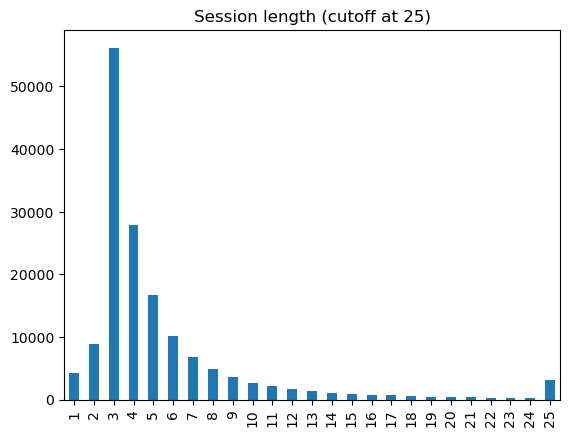

In [16]:
import matplotlib.pyplot as plt

# All sessions with lengths > cutoff get assigned cutoff
cutoff = 25
session_len = train.session_id.value_counts()
session_len[session_len>cutoff] = cutoff
session_len.value_counts().sort_index().plot(kind="bar")
plt.title(f"Session length (cutoff at {cutoff})")
plt.show()

In [17]:
# replay_buffer[(replay_buffer.len_state==2) & (replay_buffer.is_done==True)]
# The padding is very weird 
# What is item 7085 just empy item? Its state representation will have a lot of influence. Why from back to front, this would even increase its
# impact, at least for the non attention case base models (so GRU specifically)

# If len_state = 2, then 3 items were interacted with! s0->s1->s2->s3 - this refers to a session length of 4. 
# Inside the training data we still have sessions with 1 or two items - this is removed for the buffer
replay_buffer.iloc[12:18, ]

,state,len_state,action,is_buy,next_state,len_next_states,is_done
12,"[9750, 38594, 52427, 52427, 70852, 70852, 7085...",4,52427,0,"[9750, 38594, 52427, 52427, 52427, 70852, 7085...",5,False
13,"[9750, 38594, 52427, 52427, 52427, 70852, 7085...",5,52427,0,"[9750, 38594, 52427, 52427, 52427, 52427, 7085...",6,True
14,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",1,6610,0,"[6610, 70852, 70852, 70852, 70852, 70852, 7085...",1,False
15,"[6610, 70852, 70852, 70852, 70852, 70852, 7085...",1,43203,0,"[6610, 43203, 70852, 70852, 70852, 70852, 7085...",2,False
16,"[6610, 43203, 70852, 70852, 70852, 70852, 7085...",2,43203,0,"[6610, 43203, 43203, 70852, 70852, 70852, 7085...",3,True
17,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",1,25539,0,"[25539, 70852, 70852, 70852, 70852, 70852, 708...",1,False


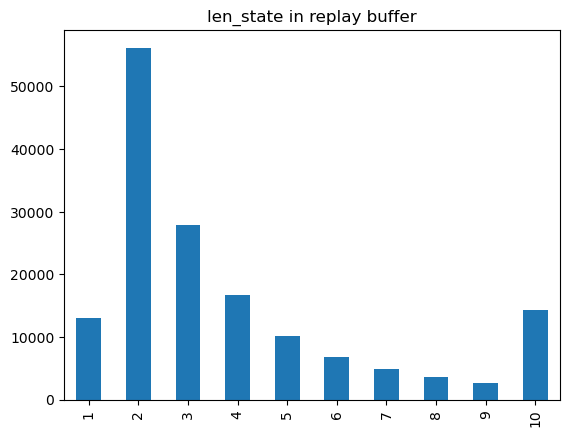

In [18]:
replay_buffer[replay_buffer.is_done==True].len_state.value_counts().sort_index().plot(kind="bar", title="len_state in replay buffer")
plt.show()

In [19]:
replay_buffer[(replay_buffer.len_state==1) & (replay_buffer.is_done==True)]
# replay_buffer.iloc[185:190]

# Throw out all session where len_state = 1 and its done immediately? 
# First try normally so as they have it, it is anyways just 13000/1Mio = <1.5% of all interactions

,state,len_state,action,is_buy,next_state,len_next_states,is_done
187,"[69518, 70852, 70852, 70852, 70852, 70852, 708...",1,35035,0,"[69518, 35035, 70852, 70852, 70852, 70852, 708...",2,True
189,"[11189, 70852, 70852, 70852, 70852, 70852, 708...",1,11189,0,"[11189, 11189, 70852, 70852, 70852, 70852, 708...",2,True
214,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",1,47274,0,"[47274, 70852, 70852, 70852, 70852, 70852, 708...",1,True
711,"[15044, 70852, 70852, 70852, 70852, 70852, 708...",1,43797,0,"[15044, 43797, 70852, 70852, 70852, 70852, 708...",2,True
771,"[39223, 70852, 70852, 70852, 70852, 70852, 708...",1,18661,0,"[39223, 18661, 70852, 70852, 70852, 70852, 708...",2,True
...,...,...,...,...,...,...,...
988246,"[1270, 70852, 70852, 70852, 70852, 70852, 7085...",1,28426,0,"[1270, 28426, 70852, 70852, 70852, 70852, 7085...",2,True
988302,"[31271, 70852, 70852, 70852, 70852, 70852, 708...",1,22678,0,"[31271, 22678, 70852, 70852, 70852, 70852, 708...",2,True
988318,"[31091, 70852, 70852, 70852, 70852, 70852, 708...",1,31091,0,"[31091, 31091, 70852, 70852, 70852, 70852, 708...",2,True
988417,"[57053, 70852, 70852, 70852, 70852, 70852, 708...",1,28988,0,"[57053, 28988, 70852, 70852, 70852, 70852, 708...",2,True


In [20]:
# Read pop dict
f = open("../data/RetailRocket/pop_dict.txt", 'r')
pop_dict = eval(f.read())
f.close()

# Pop dict is only used for SA2C to create weights between target and bevavior policy, item pop is b(a|s) and they approximate it with b(a)

In [21]:
# Read data_statis
pd.read_pickle(os.path.join(data_directory, 'data_statis.df'))

,state_size,item_num
0,10,70852


In [22]:
np.sort(replay_buffer.action.unique())

array([    0,     1,     2, ..., 70849, 70850, 70851])

In [23]:
replay_buffer.shape

(988719, 7)

### Questions:
1. The padding is weird - What is item 7085 just empy item? Its state representation will have a lot of influence. 
1. For GRU (and transformer too) we would not need to pad I guess?
1. Why from back to front, this would even increase its impact, at least for the non attention case base models (so GRU specifically)
1. Why do they use TF1?!

In [24]:
import numpy as np

# Softmax behavior
# Using logits to get probs, logit = ln p/(1-p) for 0.5 it is ln(1)=0, for 0.4/0.6 smaller 1 ln(<1)=-X, for ln(0.6)=X
# NN will map to logits, high values for > 0, small values for <0! Medium for 0. So will try to take positives high and neg low
print(np.exp(3)/(np.exp(1)+np.exp(-1)+np.exp(0)+np.exp(3)))
print(np.exp(2)/(np.exp(1)+np.exp(-1)+np.exp(0)+np.exp(2)))

0.8309526605439513
0.6439142598879724


### How to load non-image data into pytorch model?

In [25]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

map_rew_cat = np.vectorize(lambda rew_cat: 0 if rew_cat == 0  else 1)

class ReplayBuffer(Dataset):
    """
    Custom torch dataset that takes existing replay buffer file
    and samples from it during training. 

    num_items is without padding item. Take not actual number but end 
    of numeration, so that indexing is the same. 

    Returns:
    s, a, r, s', is_end
    """
    def __init__(self, dir, map_rew_cat_func, num_items, state_name="state", 
        next_state_name="next_state", action_name="action", end_name="is_done", 
        reward_cat_name="is_buy"):

        super().__init__()
        self.dir = dir
        self.num_items = num_items
        
        # Names 
        self.state_name = state_name  # s
        self.next_state_name = next_state_name  # s'
        self.action_name = action_name  # a
        self.reward_cat_name = reward_cat_name
        self.end_name = end_name 

        # Save function to map reward category to reward 
        # (assuming reward is categorical)
        self.map_rew_func = map_rew_cat_func

        # Load data 
        replay_df = pd.read_pickle(dir)

        # Transform each information column to numpy array (indexing is way faster)
        self.states = np.array(replay_df[self.state_name].values.tolist())
        self.next_states = np.array(replay_df[self.next_state_name].values.tolist())
        self.actions = replay_df[action_name].to_numpy()
        self.reward = map_rew_cat_func(replay_df[reward_cat_name].to_numpy())  
        self.is_end = replay_df[end_name].to_numpy()

        # Free memory
        del replay_df

    def __len__(self):
        return len(self.actions)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx], self.reward[idx], self.next_states[idx], self.is_end[idx]


In [26]:
buffer_set = ReplayBuffer(dir="../data/RetailRocket/replay_buffer.df", map_rew_cat_func=map_rew_cat, num_items=70852)
replay_loader = DataLoader(buffer_set, batch_size=2, shuffle=True, drop_last=False)

In [27]:
example = next(iter(replay_loader))

print(example)
print(example[0].requires_grad)

print(f"\nShape of first tensor (state): {example[0].shape}")

[tensor([[39401,  4672, 39401, 30111, 39401, 57788, 70852, 70852, 70852, 70852],
        [59728, 70852, 70852, 70852, 70852, 70852, 70852, 70852, 70852, 70852]]), tensor([31725, 14035]), tensor([0, 0]), tensor([[39401,  4672, 39401, 30111, 39401, 57788, 31725, 70852, 70852, 70852],
        [59728, 14035, 70852, 70852, 70852, 70852, 70852, 70852, 70852, 70852]]), tensor([ True, False])]
False

Shape of first tensor (state): torch.Size([2, 10])


In [28]:
# Check action tensor (it should be in indexing format for gathering, so (batch_size, 1))
example[1].shape

torch.Size([2])

In [29]:
# Cross Entropy loss with index
loss = nn.CrossEntropyLoss()
input = torch.randn(64, 700, requires_grad=True)
target = torch.empty(64, dtype=torch.long).random_(5)
output = loss(input, target)

In [30]:
output.item()

7.125010967254639

In [31]:
# There is no difference if packed in tuple or not
# You will get list of np.array items 
class Probe(Dataset):
    def __init__(self):
        self.hallo = [1.0, 2.0, 3.5]
        self.morgen = [True, False, True]
        self.hi = [["hi", "wo"], ["hi", "wo"], ["hi", "wo"]]

    def __len__(self):
        return len(self.hi)
    def __getitem__(self, idx):
        return (self.hallo[idx], self.morgen[idx], self.hi[idx])

proben = DataLoader(Probe(), batch_size=2, shuffle=True)
next(iter(proben))

[tensor([1., 2.], dtype=torch.float64),
 tensor([ True, False]),
 [('hi', 'hi'), ('wo', 'wo')]]

In [32]:
# Embedding example for matrox size

embedding = torch.nn.Embedding(10, 3, padding_idx=9)

batch = torch.LongTensor([[1,2,4,5],[4,3,2,9]])

print(f"Batch shape:      {batch.shape}")

embed = embedding(batch)

print(f"Embedding output: {embed.shape}")

Batch shape:      torch.Size([2, 4])
Embedding output: torch.Size([2, 4, 3])


Embeeding layer of size (n_vocab, dimension) and accepts batches as (batch_size, sentence_length). Batch_size also from dataloader will always be first dimension. 

In [33]:
print(embedding.weight)
embedding.weight.data.normal_(10, 1)

Parameter containing:
tensor([[ 1.6639e-01,  1.2767e-01, -1.3020e+00],
        [-4.2997e-01,  2.2181e+00,  1.9095e+00],
        [ 9.2314e-01, -6.8438e-01,  8.2680e-01],
        [-5.8228e-01, -1.0427e+00,  6.6784e-01],
        [ 3.2122e-01,  1.2160e+00,  8.6081e-01],
        [ 6.6841e-04, -1.0685e+00,  9.5289e-01],
        [ 3.8258e-01, -5.3101e-01,  5.6339e-01],
        [-3.3436e-01,  9.2094e-01,  1.1455e+00],
        [ 5.8101e-02,  1.6025e+00, -5.4979e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], requires_grad=True)


tensor([[ 8.9463,  9.5881,  9.4188],
        [10.9236,  9.5142,  9.9879],
        [10.4999, 10.4412,  9.2399],
        [10.8688,  9.8870, 11.8687],
        [10.7176,  9.0481,  9.8133],
        [10.9735,  9.8951, 10.1458],
        [ 9.4404, 11.0017, 10.1301],
        [10.2323,  9.4487,  9.8264],
        [ 9.9628,  9.8331, 10.1589],
        [10.2575, 11.4833, 10.7608]])

In [34]:
# GRU
rnn = torch.nn.GRU(input_size=10, hidden_size=20, num_layers=1, batch_first=True)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)

In [35]:
output, hn = rnn(input)
print(output.shape)

hn.shape

# Hidden state is hn. output is the hidden state for each of the positions of the sequence and each batch
# Hidden state is (layer, batch, dim_hidden)

torch.Size([5, 3, 20])


torch.Size([1, 5, 20])

In [36]:
# Softmax
m = torch.nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)

In [37]:
# Get argmax of output
print(output)

idx = torch.argmax(output, dim=1, keepdim=True)
print(idx)

tensor([[0.1791, 0.6424, 0.1785],
        [0.0832, 0.3632, 0.5536]])
tensor([[1],
        [2]])


In [38]:
output.gather(1, idx)

tensor([[0.6424],
        [0.5536]])

In [39]:
# Index transform for action value retrieval 
probe = torch.tensor([1,2,3,4])
probe.unsqueeze(dim=1)

tensor([[1],
        [2],
        [3],
        [4]])

In [40]:
class_index = torch.tensor([3])
torch.nn.functional.one_hot(class_index, num_classes=10)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [41]:
# Transform actions to One-Hot Vector (more efficient to do it here for each batch,
# transforming the whole actions vector took too much memory, crashed, sparse but huge)
# If action=10 then one_hot[10]=1
# action = nn.functional.one_hot(torch.tensor(self.actions[idx]), num_classes=self.num_items+1)

In [42]:
988000/256

3859.375

In [43]:
# Assign 0 to end states
is_end = torch.tensor([True, False, True])
vals = torch.tensor([10,20,30])

vals[is_end] = 0.0
vals

tensor([ 0, 20,  0])

## Evaluation method

Goal: Dataframe with cols (padded) state, action, reward and number of total actions per action category (customer can click product or purchase it, each own category)

**NOTE:** Are we only assessing the interactions with the inspirational feed? So the next one to interact with? So just HR(click/view of IFI)@k? 

**NOTE 2:** They only use one of the trained networks for evaluation. Could be nice to alternate.

In [44]:
# Padding items are added to right side
a = [1,2,3]
a.extend([5])
a

[1, 2, 3, 5]

In [45]:
val["n_items_bef"] = val.groupby("session_id").cumcount()
val

,timestamp,session_id,item_id,is_buy,n_items_bef
1361687,1442004589439,0,43511,0,0
1367212,1442004759591,0,54408,0,1
1367342,1442004917175,0,10006,0,2
1663634,1431581976753,3,21080,0,0
1655502,1431582162817,3,24928,0,1
...,...,...,...,...,...
337403,1434585232543,195520,12794,0,1
346677,1434585240943,195520,38719,0,2
339623,1434585258746,195520,39674,0,3
346680,1434585284740,195520,38719,0,4


In [46]:
examp = val[val.session_id==195520]
examp

,timestamp,session_id,item_id,is_buy,n_items_bef
331264,1434585145087,195520,38719,0,0
337403,1434585232543,195520,12794,0,1
346677,1434585240943,195520,38719,0,2
339623,1434585258746,195520,39674,0,3
346680,1434585284740,195520,38719,0,4
339600,1434585451071,195520,12794,0,5


In [47]:
def get_state(n_items_bef, item_hist, state_len, pad_id):
    """
    Function to retrieve colum of states given a groups n_items_bef column.
    To keep in line with the paper's implementation, the returned seqs are
    of form [oldest, ..., newest, pad, ..., pad].
    """
    if n_items_bef >= state_len:  # We have enough experience to fill state without padding
        return item_hist[n_items_bef-state_len:n_items_bef]  # Return state_len actions before (history - not including current action)
    else:  # Padding needed
        n_pad = state_len - n_items_bef
        pad_list = [pad_id] * n_pad
        return np.pad(item_hist[:n_items_bef], pad_width=(0, n_pad), mode="constant", constant_values=pad_id)


def get_state_col(group_df, pad_id, state_len, item_before_col="n_items_bef", item_id_col="item_id"):
    """
    Take group_df and return column with (padded) states. 
    """
    item_hist = group_df[item_id_col].values

    session_states = group_df[item_before_col].apply(get_state, 1, item_hist=item_hist, state_len=state_len, pad_id=pad_id)

    return session_states

In [48]:
# Transform them into states

val["state"] = val.groupby("session_id", group_keys=False).apply(get_state_col, pad_id=70852, state_len=2)
val

,timestamp,session_id,item_id,is_buy,n_items_bef,state
1361687,1442004589439,0,43511,0,0,"[70852, 70852]"
1367212,1442004759591,0,54408,0,1,"[43511, 70852]"
1367342,1442004917175,0,10006,0,2,"[43511, 54408]"
1663634,1431581976753,3,21080,0,0,"[70852, 70852]"
1655502,1431582162817,3,24928,0,1,"[21080, 70852]"
...,...,...,...,...,...,...
337403,1434585232543,195520,12794,0,1,"[38719, 70852]"
346677,1434585240943,195520,38719,0,2,"[38719, 12794]"
339623,1434585258746,195520,39674,0,3,"[12794, 38719]"
346680,1434585284740,195520,38719,0,4,"[38719, 39674]"


In [49]:
val[val.session_id==195505].state.apply(lambda x: len(x))

2722159    2
2734128    2
2728505    2
Name: state, dtype: int64

In [31]:
# Reward mapping

def action_to_reward(action_type, a_to_r_dict):
    return a_to_r_dict[action_type]

a_to_r_dict = {0:0.2, 1:1}  # Here just buy:1, click:0.2

val["reward"] = val.is_buy.apply(action_to_reward, 1, a_to_r_dict=a_to_r_dict)

NameError: name 'val' is not defined

In [51]:
def get_total_actions(df, action_type_col="is_buy"):
    return df[action_type_col].value_counts()

get_total_actions(val)

0    118306
1      5291
Name: is_buy, dtype: int64

In [52]:
batch = torch.tensor(np.array(val.state.sample(100).to_list()))
batch.shape

torch.Size([100, 2])

In [53]:
# Pack it in dataset and dataloader to only make changes once 
# and stores the big dataset on local memory to then send the 
# batches to GPU

from torch.utils.data import Dataset, DataLoader

class EvaluationDataset(Dataset):
    """
    Custom torch dataset that takes existing val/test file,
    transforms it and samples from it during training. 

    Returns:
    s, a, r
    """
    def __init__(self, dir, padding_id, 
            state_len, action_to_reward_dict, action_type_name="is_buy", 
            session_id_name="session_id", action_name="item_id", item_id_name="item_id"):

        super().__init__()

        eval_df = pd.read_pickle(dir)
        self.pad_id = padding_id
        self.state_len = state_len
        self.a_to_r = action_to_reward_dict

        # Add column with number of items before in the session
        eval_df["n_items_bef"] = eval_df.groupby(session_id_name).cumcount()

        # Add column for (padded) state representation
        eval_df["state"] = eval_df.groupby(session_id_name, group_keys=False).apply(get_state_col, pad_id=self.pad_id, state_len=self.state_len, item_id_col=item_id_name)

        # Add reward column 
        eval_df["reward"] = eval_df[action_type_name].apply(action_to_reward, 1, a_to_r_dict=self.a_to_r)

        eval_df = eval_df.iloc[:10000,:]

        # Transform each information column to numpy array (indexing is way faster)
        self.states = np.array(eval_df["state"].values.tolist())
        self.actions = eval_df[action_name].to_numpy()
        self.reward = eval_df["reward"].to_numpy()
        self.action_type = eval_df[action_type_name].to_numpy()

        # Free memory
        del eval_df
        
    def __len__(self):
        return len(self.actions)
    
    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx], self.reward[idx], self.action_type[idx]

In [85]:
from recommenders.SQN.evaluation import EvaluationDataset


val_set = EvaluationDataset(dir="../data/RetailRocket/sampled_train.df", padding_id=70852, state_len=10, action_to_reward_dict=a_to_r_dict)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, drop_last=False)

example = next(iter(val_loader))

print(example)

print(f"\nShape of first tensor (state): {example[0].shape}")

[tensor([[70852, 70852, 70852, 70852, 70852, 70852, 70852, 70852, 70852, 70852],
        [49432, 70852, 70852, 70852, 70852, 70852, 70852, 70852, 70852, 70852],
        [49432, 49432, 70852, 70852, 70852, 70852, 70852, 70852, 70852, 70852],
        [49432, 49432, 39563, 70852, 70852, 70852, 70852, 70852, 70852, 70852]]), tensor([49432, 49432, 39563, 32776]), tensor([0.2000, 0.2000, 0.2000, 0.2000], dtype=torch.float64), tensor([0, 0, 0, 0])]

Shape of first tensor (state): torch.Size([4, 10])


In [55]:
# Note: Looks good. But in general, what happens if we are in first state with 0 information? We should start a bit later? I dont know
val

,timestamp,session_id,item_id,is_buy,n_items_bef,state,reward
1361687,1442004589439,0,43511,0,0,"[70852, 70852]",0.2
1367212,1442004759591,0,54408,0,1,"[43511, 70852]",0.2
1367342,1442004917175,0,10006,0,2,"[43511, 54408]",0.2
1663634,1431581976753,3,21080,0,0,"[70852, 70852]",0.2
1655502,1431582162817,3,24928,0,1,"[21080, 70852]",0.2
...,...,...,...,...,...,...,...
337403,1434585232543,195520,12794,0,1,"[38719, 70852]",0.2
346677,1434585240943,195520,38719,0,2,"[38719, 12794]",0.2
339623,1434585258746,195520,39674,0,3,"[12794, 38719]",0.2
346680,1434585284740,195520,38719,0,4,"[38719, 39674]",0.2


In [1]:
# After that we get predictions

from recommenders.SQN.model import SQN

sqn = SQN(
        hidden_dim=10, 
        embedding_dim=10,
        learning_rate=0.01, 
        item_num=70852,
        state_size=10,
        action_dim=70852,
        gamma=0.5, 
        device="cpu",
        action_types=[0,1],
        action_types_dict={0:"click", 1:"purchase"})
    
# Send to device
sqn.send_to_device()

sup_pred, q_pred = sqn.DQN_1(batch)

NameError: name 'batch' is not defined

In [57]:
sqn.action_types_dict

{0: 'click', 1: 'purchase'}

In [58]:
sup_pred.shape

torch.Size([100, 70852])

In [59]:
torch.argmax(sup_pred, dim=1)

tensor([58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370,
        58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370,
        58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370,
        58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370,
        58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370,
        58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370,
        58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370, 58370,
        58370, 58370, 58370, 20073, 58370, 58370, 58370, 58370, 58370, 58370,
        58370, 58370, 58370, 58370, 58370, 20073, 58370, 58370, 58370, 58370,
        58370, 58370, 58370, 58370, 58370, 58370, 58370, 20073, 58370, 58370])

In [60]:
print(sup_pred[0, 63564])

max(sup_pred[0,:])

tensor(-0.3306, grad_fn=<SelectBackward0>)


tensor(0.5643, grad_fn=<UnbindBackward0>)

In [61]:
%%timeit
torch.argsort(sup_pred)

107 ms ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
%%timeit
_ , idx = torch.topk(sup_pred, k=10)

# A lot faster to use argpartition/topk!!

2.78 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
a = torch.tensor([[1,5,7,19, 4, 3, 2, 4, 10], [10,11,12,13, 4, 3, 2, 4, 0]])

print(a)

vals, idx = torch.topk(a, k=3)
vals
print(idx)

tensor([[ 1,  5,  7, 19,  4,  3,  2,  4, 10],
        [10, 11, 12, 13,  4,  3,  2,  4,  0]])
tensor([[3, 8, 2],
        [3, 2, 1]])


In [64]:
# Check if in tensor 
print(1 in idx)

np_idx = idx.numpy()
np.apply_along_axis(lambda x: 1 in x, 1, np_idx)

True


array([False,  True])

In [65]:
val_arr = np.array([[1,2,3], [4,5,6]])
check = np.array([[1], [2]])

val_arr

array([[1, 2, 3],
       [4, 5, 6]])

In [66]:
def is_in(a, b):
    print("a ", a)
    print("b ", b)
    return b ==a
vectorized_isin = np.vectorize(is_in)

vectorized_isin(np.array([[1,2,3],[10,20,30]]), np.array([[3],[10]]))

# This only works if b has one element in each! Not of multiple only then exactly same shape!!!

a  1
b  3
a  1
b  3
a  2
b  3
a  3
b  3
a  10
b  10
a  20
b  10
a  30
b  10


array([[False, False,  True],
       [ True, False, False]])

In [67]:
# Write custom vectorized function

check = np.array([[1,2,3],[10,20,30]])
val_arr = np.array([[3],[10]])

@np.vectorize
def compare_elements(array_to_check, vals_to_find):
    """
    array_to_check contains rows with labels and 
    check for each row if vals_to_find in this row
    is in the according row of array_to_check.
    """
    return array_to_check==vals_to_find

# Vectorizing will apply the function to each element in 
# array_to_check and compare it to the according value in
# the row of vals_to_find

print(check)
print(val_arr)
print(compare_elements(check, val_arr))

[[ 1  2  3]
 [10 20 30]]
[[ 3]
 [10]]
[[False False  True]
 [ True False False]]


In [68]:
# Now on top define funciton that returns any() of each row to get desired output per row

def is_in(array_to_check, vals_to_find):
    """
    Apply the vectorized compare_element function and
    squeeze output for each row to True if one of the 
    elements was the same as the value to compare, False
    respectively. 
    """
    return compare_elements(array_to_check, vals_to_find).any(1)

is_in(check, val_arr)

array([ True,  True])

In [69]:
top_k = [5, 10, 20]
max_k = max(top_k)

# True idx of action
true_idx = torch.tensor(63564).repeat(100)

# Idx has size (batch, maxk) so top max_k preds
_ , idx = torch.topk(sup_pred, k=max_k)

# Transform to numpy 
idx = idx.numpy()
true_idx = true_idx.unsqueeze(1).numpy()

hit_list = []
for k in top_k:
    # Check if true_idx is in top-k (:k!) predictions and sum for how many rows this is true
    hits_k = is_in(idx[:,:k], true_idx).sum()
    #hits_k = np.apply_along_axis(lambda top_idx_row: true_idx in top_idx_row[:,:k], 1, idx).sum()a
    hit_list.append(hits_k)

hit_list

[0, 0, 0]

In [70]:
idx.shape

(100, 20)

In [71]:
# Important to save it!!!
a = torch.tensor([1,2,3], requires_grad=False)
a.device
a = a.to("mps")
a.device

device(type='mps', index=0)

In [72]:
sqn.DQN_1
#sqn.to("mps")

SQN_Network(
  (embedding): Embedding(70853, 10, padding_idx=70852)
  (base_model): GRU(10, 10, batch_first=True)
  (sup_head_output): Linear(in_features=10, out_features=70852, bias=True)
  (q_head_output): Linear(in_features=10, out_features=70852, bias=True)
)

In [73]:
# from recommenders.SQN.evaluation import EvaluationDataset

val_set = EvaluationDataset(dir="../data/RetailRocket/sampled_val.df", padding_id=70852, state_len=10, action_to_reward_dict=a_to_r_dict, action_name="item_id")
val_loader = DataLoader(val_set, batch_size=250, shuffle=False, drop_last=False, prefetch_factor=2)

In [74]:
sqn = SQN(
        hidden_dim=10, 
        embedding_dim=10,
        learning_rate=0.01, 
        item_num=70852,
        state_size=10,
        action_dim=70852,
        gamma=0.5, 
        device="cpu",
        action_types=[0,1],
        action_types_dict={0:"click", 1:"purchase"})
    
# Send to device
sqn.send_to_device()

In [78]:
from recommenders.SQN.evaluation import evaluate

evaluate(val_loader, sqn.DQN_1, device=sqn.device, top_k=[5,10], action_types=sqn.action_types, action_types_dict=sqn.action_types_dict, head="sup_head", loss_function=sqn.cross_entropy_loss)

(tensor(11.1976),
 {'click': tensor([0.0001, 0.0001], dtype=torch.float64),
  'purchase': tensor([0., 0.], dtype=torch.float64),
  'total': tensor([1.0000e-04, 1.0000e-04], dtype=torch.float64)},
 {'click': tensor([6.5185e-05, 6.5185e-05], dtype=torch.float64),
  'purchase': tensor([0., 0.], dtype=torch.float64),
  'total': tensor([6.3093e-05, 6.3093e-05], dtype=torch.float64)})

In [ ]:
from recommenders.SQN.evaluation import compute_HR
import cProfile
import pstats 

with cProfile.Profile() as prof:
    compute_HR(val_loader, sqn.DQN_1, device=sqn.device, top_k=[5,10], action_types=sqn.action_types, action_types_dict=sqn.action_types_dict, head="sup_head")

pstats.Stats(prof).strip_dirs().sort_stats('cumulative').print_stats(10)

# prof.print_stats()

ImportError: cannot import name 'compute_HR' from 'src.SQN.evaluation' (/Users/patrickhiemsch/Documents/Python_projects/Recomender-Models/src/SQN/evaluation.py)

In [ ]:
compute_HR(val_loader, sqn.DQN_1, device=sqn.device, top_k=[5,10], action_types=sqn.action_types, action_types_dict=sqn.action_types_dict, head="sup_head")

NameError: name 'compute_HR' is not defined

#### NDCG

In [79]:
# 1/log2(rank+1)
print(f"Rank 1: {1/np.log2(1+1):.2f}")
print(f"Rank 2: {1/np.log2(2+1):.2f}")
print(f"Rank 3: {1/np.log2(3+1):.2f}")
print(f"Rank 5: {1/np.log2(5+1):.2f}")
print(f"Rank 10: {1/np.log2(10+1):.2f}")
print(f"Rank 20: {1/np.log2(20+1):.2f}")

# At first fast decay, then slower! 1 vs 5 is big difference, but 10 vs. 20 less important!

Rank 1: 1.00
Rank 2: 0.63
Rank 3: 0.50
Rank 5: 0.39
Rank 10: 0.29
Rank 20: 0.23


In [80]:
# Replicate forevaluation funciton 

@np.vectorize
def compare_elements(array_to_check, vals_to_find):
    """
    array_to_check contains rows with labels and 
    check for each row if vals_to_find in this row
    is in the according row of array_to_check.

    Vectorizing will apply the function to each element in 
    array_to_check and compare it to the according value in
    the row of vals_to_find.
    """
    return array_to_check==vals_to_find



def check_existence_and_rank(array_to_check, vals_to_find):
    """
    Apply the vectorized compare_element function and
    squeeze output for each row to True if one of the 
    elements was the same as the value to compare, False
    respectively into a mask. 
    
    Init result array with 0,
    0 means true value not included in top-k result. 

    Apply mask to result array, if mask=True, value is 
    included in top-k preds. Then get argmax of respective
    row, which produces index/rank, since max. one  True 
    element per row. 

    Note: If true label is top-1 pred, will also produce 0. That
    is why 1 is added to all indexes. This way 0:Not included, >=1:Rank.

    NDCG expects rank (=index+1) anyways.
 
    array_to_check: (batch_size, k) - Top-k prediction indexes (taken from topk applied on forward pass)
    vals_to_find: (batch_size) - True action taken by user/ True index of action/item in output vector of NN
    """

    # Get bool array (batch_size, k) for matching of values rowwise
    element_wise_comp_array = compare_elements(array_to_check, vals_to_find)

    # Get mask to check which rows contain true label
    mask = element_wise_comp_array.any(1)

    rank_result = np.zeros(shape=len(vals_to_find))
    rank_result[mask] = np.argmax(element_wise_comp_array[mask], axis=1) + 1  

    return mask, rank_result

preds = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [100,11,12]])
vals, idx = torch.topk(preds, k=3)
vals, idx = vals.numpy(), idx.numpy()

true_labs = np.array([[2], [21], [7], [21]])

check_existence_and_rank(vals, true_labs)


(array([ True, False,  True, False]), array([2., 0., 3., 0.]))

In [81]:
np.where(true_labs in vals)

(array([0]),)

In [82]:
a = np.array([1.0,2,3])
b = np.array([1.0,2,0])

np.divide(a, b, out=np.zeros_like(a), where=b!=0)

array([1., 1., 0.])

In [83]:
# Update global dict 
Test = {"1":"2"}
def Teser(t):
    # you can still reference t values, if needed 
    global Test  # while not necessary, it clarifies which variable scope is used 
    Test['1'] = 23
Teser(Test)
print(Test)

{'1': 23}


#### Evaluation metric test

In [84]:
# Test the actual evaluation implementations
from recommenders.SQN.evaluation import create_metric_dicts, get_hits_for_batch

action_types = [0,1]
action_types_dict = {0:"click", 1:"buy"}
top_k = [1,2,10]

# Initialize result dicts for hr/ndcg/action-type-count
action_types_hit_dict, action_types_ndcg_dict, action_types_count = create_metric_dicts(action_types, action_types_dict, top_k)
action_types_hit_dict 

# For each action type (+ total) we have a numpy array for counts based on top-k

{'click': array([0., 0., 0.]),
 'buy': array([0., 0., 0.]),
 'total': array([0., 0., 0.])}

In [85]:
# Set batch
a_type = torch.tensor([0,0,0,0,0,0,1,1,1])
a = torch.tensor([9,0,2,1,1,1,9,0,1])  # top 1: rrrwww rrw, top 2: rrrwrw rrr, top 10: rrrrrrrrr

# Set preds: (batch, num_actions)
preds = torch.tensor([[1,2,3,4,5,6,7,8,9,10],  # 9 c
                      [10,9,8,7,6,5,4,3,2,1],  # 0 c
                      [1,2,100,2,2,2,2,2,2,2], # 2 c
                      [1,2,3,4,5,6,7,8,9,10],  # 9 c
                      [10,9,8,7,6,5,4,3,2,1],  # 0 c
                      [1,1,100,2,2,2,2,2,2,2], # 2 c
                      [1,2,3,4,5,6,7,8,9,10],  # 9 b
                      [10,9,8,7,6,5,4,3,2,1],  # 0 b
                      [1,3,100,2,2,2,2,2,2,2]  # 2 b
                      ])

# Expected result for k= 1,2,10
# HIT-RATIO: clicks: 0.5, 2/3, 1         | buys: 2/3, 1, 1           | total: 0.5556, 0.7778, 1.0000
# NDCG:      clicks: 0.5, 0.6051, 0.7055 | buys: 2/3, 0.8767, 0.8767 | total: 0.5556, 0.6958, 0.7627
# NDCG treats worse rankings lower, so a mdoel with higher ranking true labels will be better!

# Calc examples: 1+1+1+1/np.log2(2+1)=0.6051
# For total: 6/9 * 0.5 + 3/9 * 0.6667 = 0.5556


for curr_type in action_types:

    # Get mask of where tensor a_type matches current action 
    mask = a_type==curr_type

    # Jump to next action, if empty
    if mask.sum()==0:
        continue

    # Get number of hits in action-batch for each k
    total_hits_per_k, total_ndcg_per_k = get_hits_for_batch(predictions=preds[mask], true_idx=a[mask], top_k=top_k)

    # Add k-hits numpy array to current array to accumulate over batches
    action_types_hit_dict[action_types_dict[curr_type]] += total_hits_per_k
    action_types_hit_dict["total"] += total_hits_per_k

    # Add k-ndcg numpy array to current array to accumulate over batches
    action_types_ndcg_dict[action_types_dict[curr_type]] += total_ndcg_per_k
    action_types_ndcg_dict["total"] += total_ndcg_per_k

    # Add number of examples to total count
    n_act = mask.sum()
    action_types_count[action_types_dict[curr_type]] += n_act
    action_types_count["total"] += n_act

# Calculate hit ratio 
for key, val in action_types_hit_dict.items():
    action_types_hit_dict[key] = val / action_types_count[key]

# Calculate ndcg ratio 
for key, val in action_types_ndcg_dict.items():
    action_types_ndcg_dict[key] = val / action_types_count[key]

print(action_types_hit_dict)
print("")
print(action_types_ndcg_dict)
                                                                            

{'click': tensor([0.5000, 0.6667, 1.0000], dtype=torch.float64), 'buy': tensor([0.6667, 1.0000, 1.0000], dtype=torch.float64), 'total': tensor([0.5556, 0.7778, 1.0000], dtype=torch.float64)}

{'click': tensor([0.5000, 0.6052, 0.7055], dtype=torch.float64), 'buy': tensor([0.6667, 0.8770, 0.8770], dtype=torch.float64), 'total': tensor([0.5556, 0.6958, 0.7627], dtype=torch.float64)}


In [87]:
a = pd.DataFrame({"item_id":[10,20,30,40,50,60,70],
             "n_items_bef":[0,1,2,3,4,5,6]})

b = pd.DataFrame({"State":[[999,999,999],
[10,999,999],
[10,20,999],
[10,20,30],
[20,30,40],
[30,40,50],
[40,50,60]]})
def get_state_col(group_df, pad_id, state_len, item_before_col="n_items_bef", action_name="item_id"):
    """
    Take group_df and return column with (padded) states. 

    action_name: Column name for actions taken 
    """
    item_hist = group_df[action_name].values

    session_states = group_df[item_before_col].apply(get_state, 1, item_hist=item_hist, state_len=state_len, pad_id=pad_id)

    return session_states

res = get_state_col(a, 999,3,)


ass = True
for i in range(len(res)):
    if not (res.iloc[i]==b.iloc[i,0]).all():
        ass = False

In [99]:
from recommenders.SQN.evaluation import action_to_reward
a_to_r_dict = {0: 10, 1:100, 2:200}
test_df = pd.DataFrame({"Action_type":[0,0,0,1,2,2], 
                        "Other_col":[1,2,3,4,5,6]})

# As in evaluation framework, apply along to col 
np.equal(test_df.Action_type.apply(action_to_reward, 1, a_to_r_dict=a_to_r_dict).values, [10,10,10,100,200,200]).all()

True

In [17]:
# Create example pickle file 
from recommenders.SQN.evaluation import EvaluationDataset
sessions = [11, 11, 11, 11, 22, 22, 22, 22, 22, 22, 33, 33]
items  = [1,2,3,4,6,7,8,9,10,11,100,101]
act_types = [0,0,0,1,0,0,1,0,0,0,1,1]

data = {"SessionID":sessions,
        "Item": items,
        "ActionType": act_types}
pd_data = pd.DataFrame(data)

# Save as pickle
# pd_data.to_pickle("../test/eval_data_transform_test.df")

load_examp = EvaluationDataset(dir="../test/data_transform_test.df", 
                        padding_id=999, state_len=3, 
                        action_to_reward_dict={0:10, 1:50}, 
                        pad_pos="beg",
                        action_type_name="ActionType",
                        session_id_name="SessionID",
                        action_name="Item")
pd_data

,SessionID,Item,ActionType
0,11,1,0
1,11,2,0
2,11,3,0
3,11,4,1
4,22,6,0
5,22,7,0
6,22,8,1
7,22,9,0
8,22,10,0
9,22,11,0


In [23]:
# Truth
truth = np.array([[999, 999, 999],
            [  1, 999, 999],
            [  1,   2, 999],
            [  1,   2,   3],
            [999, 999, 999],
            [  6, 999, 999],
            [  6,   7, 999],
            [  6,   7,   8],
            [  7,   8,   9],
            [  8,   9,  10],
            [999, 999, 999],
            [100, 999, 999]])

[[999 999 999]
 [999 999   1]
 [999   2   1]
 [  3   2   1]
 [999 999 999]
 [999 999   6]
 [999   7   6]
 [  8   7   6]
 [  9   8   7]
 [ 10   9   8]
 [999 999 999]
 [999 999 100]]


array([[999, 999, 999],
       [999, 999,   1],
       [999,   1,   2],
       [  1,   2,   3],
       [999, 999, 999],
       [999, 999,   6],
       [999,   6,   7],
       [  6,   7,   8],
       [  7,   8,   9],
       [  8,   9,  10],
       [999, 999, 999],
       [999, 999, 100]])

In [4]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard.summary import hparams
class CorrectedSummaryWriter(SummaryWriter):
    def add_hparams(self, hparam_dict, metric_dict):
        torch._C._log_api_usage_once("tensorboard.logging.add_hparams")
        if type(hparam_dict) is not dict or type(metric_dict) is not dict:
            raise TypeError('hparam_dict and metric_dict should be dictionary.')
        exp, ssi, sei = hparams(hparam_dict, metric_dict)
        
        self.file_writer.add_summary(exp)
        self.file_writer.add_summary(ssi)
        self.file_writer.add_summary(sei)
        for k, v in metric_dict.items():
            self.add_scalar(k, v)

In [6]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
# Tensorboard:
# Setup tensorboard logging
writer = CorrectedSummaryWriter(f'TENSORB/Exp_3'  , )


# Log to Tensorboard
for i in range(1,101):
    writer.add_scalar('loss_train', np.log(i)*np.random.uniform(), i)
    writer.add_scalar('lr', 1, i)
    #writer.add_scalars("LvsA", {"L":np.random.uniform(), "A":np.random.uniform()*10}, i)
# writer.add_scalar('Q-Modification-Signal', train_q_losses[epoch], epoch)
# writer.add_scalar('Supervised Validation Loss', val_loss, epoch)
# writer.add_scalar('Supervised loss: Training', train_sup_losses[epoch], epoch)
#plt.figure(figsize=(4,2), dpi=300)
#plt.plot(np.log(range(1,101)), range(1,101))
#plt.title("Morgen")
# writer.add_figure("Komt der weihanchtsmann", plt.gcf())
writer.add_hparams({"lr":0.001}, {"Acc":0.099})
writer.flush()
writer.close()

In [ ]:
layout = {
    "Train/Val": {
        "Loss 1": ["Multiline", ["loss_train", "loss_validation"]],
        "Loss 2": ["Multiline", ["accuracy_train", "accuracy_validation"]],
    },
}

writer.add_custom_scalars(layout)

In [ ]:
# Backup tconfig 
config={"seed_torch":1,
                "learning_rate": LR,
                "base_model": BASE_MODEL,
                "dataset": TRAIN_DIR,
                "epochs": N_EPOCHS,
                "train_batch_size": BATCH_SIZE,
                "val_batch_size": VAL_BATCH_SIZE,
                "state_size": STATE_SIZE,
                "embedding_size": EMBEDDING_SIZE,
                "hidden_state_size": HIDDEN_STATE_SIZE,
                "gamma": GAMMA, 
                "padding_id": PADDING_ID,
                "padding_pos":PADDING_POS,
                "top_k": TOP_K,
                "num_items": NUM_ITEMS,
                "device":DEVICE,
                "action_types:":ACTION_TYPES,
                "action_types_dict":ACTION_TYPES_DICT,
                "action_to_reward":ACTION_TO_REW_DICT},

In [52]:
a = pd.DataFrame({"ab":[1,1,1,2,2,2], "cd":[5,6,7,8,9,10]})
a["before"] = a.groupby("ab").cumcount()

a["is_end"] = (a.groupby("ab").before.transform("last") == a.before).astype(int)
a

,ab,cd,before,is_end
0,1,5,0,0
1,1,6,1,0
2,1,7,2,1
3,2,8,0,0
4,2,9,1,0
5,2,10,2,1


In [72]:
from recommenders.data_utils.preprocessing import preprocess_train_data
buf = preprocess_train_data(dir="../data/RetailRocket/sampled_train.df", 
                      padding_id=70852,
                      pad_pos="end",
                      action_to_reward_dict={0:0.2, 1:1},
                      state_len=10)

In [73]:
buf

,state,action,next_state,action_type,is_end
742616,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",49432,"[49432, 70852, 70852, 70852, 70852, 70852, 708...",0,False
735273,"[49432, 70852, 70852, 70852, 70852, 70852, 708...",49432,"[49432, 49432, 70852, 70852, 70852, 70852, 708...",0,False
737711,"[49432, 49432, 70852, 70852, 70852, 70852, 708...",39563,"[49432, 49432, 39563, 70852, 70852, 70852, 708...",0,False
726292,"[49432, 49432, 39563, 70852, 70852, 70852, 708...",32776,"[49432, 49432, 39563, 32776, 70852, 70852, 708...",0,False
737615,"[49432, 49432, 39563, 32776, 70852, 70852, 708...",52161,"[49432, 49432, 39563, 32776, 52161, 70852, 708...",0,False
...,...,...,...,...,...
2642325,"[2023, 35206, 17613, 70852, 70852, 70852, 7085...",8618,"[2023, 35206, 17613, 8618, 70852, 70852, 70852...",0,False
2755781,"[2023, 35206, 17613, 8618, 70852, 70852, 70852...",55283,"[2023, 35206, 17613, 8618, 55283, 70852, 70852...",0,False
2742528,"[2023, 35206, 17613, 8618, 55283, 70852, 70852...",70386,"[2023, 35206, 17613, 8618, 55283, 70386, 70852...",0,False
656195,"[2023, 35206, 17613, 8618, 55283, 70386, 70852...",12338,"[2023, 35206, 17613, 8618, 55283, 70386, 12338...",0,False


In [74]:
replay_buffer

# Works like a charm 

NameError: name 'replay_buffer' is not defined

In [91]:
from recommenders.data_utils.preprocessing import preprocess_train_data
train_beg_pad = preprocess_train_data(dir="../test/data_transform_test.df", 
                      padding_id=999,
        state_len=3,
        action_to_reward_dict={0: 10, 1: 50},
        pad_pos="beg",
        action_type_name="ActionType",
        session_id_name="SessionID",
        action_name="Item",)
train_beg_pad

,state,action,reward,next_state,action_type,is_end
0,"[999, 999, 999]",1,10,"[999, 999, 1]",0,False
1,"[999, 999, 1]",2,10,"[999, 1, 2]",0,False
2,"[999, 1, 2]",3,10,"[1, 2, 3]",0,False
3,"[1, 2, 3]",4,50,"[2, 3, 4]",1,True
4,"[999, 999, 999]",6,10,"[999, 999, 6]",0,False
5,"[999, 999, 6]",7,10,"[999, 6, 7]",0,False
6,"[999, 6, 7]",8,50,"[6, 7, 8]",1,False
7,"[6, 7, 8]",9,10,"[7, 8, 9]",0,False
8,"[7, 8, 9]",10,10,"[8, 9, 10]",0,False
9,"[8, 9, 10]",11,10,"[9, 10, 11]",0,True


In [18]:
# GPU: 6.6GB for 1000 and 5000
# Progress bar
from tqdm import tqdm
from time import sleep

data_loader = list(range(100))

for epoch in range(4):
    for i, j in enumerate(tqdm(data_loader, desc=f"Epoch {epoch}", unit="batch")):
        sleep(0.01)

Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 81.41batch/s]


In [21]:
import csv
a = {"hallo":13,
 "morgen":10}

def dict_to_csv(top_k_dict, topk, dir, csv_name):
    csv_path = os.path.join(dir, csv_name)
    with open(csv_path, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=dict.keys())
        writer.writeheader()
        writer.writerow(dict)

In [53]:
import numpy as np
import os
top_k = [5,10,20]
a = {"click":np.array([1,2,3]), "buy":np.array([5,5,5])}
csv_path = os.path.join(".", "Names.csv")
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["k"]+list(a.keys()))
    writer.writerows(zip(top_k, *a.values()))

In [54]:
pd.read_csv("./Names.csv")

,k,click,buy
0,5,1,5
1,10,2,5
2,20,3,5


In [58]:
def get_logging_dict(top_k, action_types_names, train_hit_ratio, train_ndcg, val_hit_ratio, val_ndcg):
    """
    Get dictionary with all metrics for the evaluation
    metrics, for each action and k:
    - HR@k-Action
    - NDCG@k-Action
    """
    for i, k in enumerate(top_k):
        epoch_log_res = {}
        for a_t in list(action_types_names) + ["total"]:
            type_desc = a_t.capitalize()
            epoch_log_res[
                f"Train_HR@{k}[{type_desc}]"
            ] = train_hit_ratio[a_t][i]
            epoch_log_res[
                f"Train_NDCG@{k}[{type_desc}]"
            ] = train_ndcg[a_t][i]
            epoch_log_res[f"Val_HR@{k}[{type_desc}]"] = val_hit_ratio[a_t][i]
            epoch_log_res[f"Val_NDCG@{k}[{type_desc}]"] = val_ndcg[a_t][i]

    return epoch_log_res

get_logging_dict([5,10], ["click", "purch"], {"click":[10,20], "purch":[100,200], "total":[300,400]}, 
{"click":[10,20], "purch":[100,200], "total":[300,400]}, {"click":[10,20], "purch":[100,200], "total":[300,400]}, {"click":[10,20], "purch":[100,200], "total":[300,400]})

{'Train_HR@10[Click]': 20,
 'Train_NDCG@10[Click]': 20,
 'Val_HR@10[Click]': 20,
 'Val_NDCG@10[Click]': 20,
 'Train_HR@10[Purch]': 200,
 'Train_NDCG@10[Purch]': 200,
 'Val_HR@10[Purch]': 200,
 'Val_NDCG@10[Purch]': 200,
 'Train_HR@10[Total]': 400,
 'Train_NDCG@10[Total]': 400,
 'Val_HR@10[Total]': 400,
 'Val_NDCG@10[Total]': 400}

In [ ]:
# The actions must be ordered, from 0 to max_action! For the predicitons and comps to make sense!
# Also loss computations, here Q/Action is picked from this index so no 1, 100, 123432, - 0,1,2,...,max